In [1]:
#% shift enter to run section
#% Place cursors where the split is desired, and then press and release ctrl + shift + -
#% Multiple cursors may be placed, by holding ctrl, and clicking the location for the cursor
#% Select the desired, consecutive cells, by holding shift, and clicking in the margin, where the [ ] is, which will highlight the selected cells.
#% While still holding shift, press m, and then release both keys.
import pdb
import pylab,pyreadr,tqdm,tzlocal,sys,os,netCDF4
import pandas as pd
from tqdm._tqdm_notebook import tqdm_notebook
import numpy as np
import numpy.ma as ma
from numpy import *
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.image import pil_to_array
plt.style.use('ggplot')
import xarray as xr
from glob import glob
from netCDF4 import Dataset
import matplotlib.mlab as mlab
import seaborn as sns
import scipy.interpolate as sc
from scipy import signal
my_timezone = tzlocal.get_localzone().zone
# pylab for more MATLAB like environment and inline displays plots below cells
%pylab inline
# if gsw Warning shows, manually install gsw if possible - will still work without
import glidertools as gt
from cmocean import cm as cmo  # we use this for colormaps
#del()
import geostatspy.GSLIB as GSLIB 
import geostatspy.geostats as geostats 
import scipy.stats   
from skgstat import Variogram
import pykrige
from sklearn.linear_model import LinearRegression
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
pandas2ri.activate()
readRDS = robjects.r['readRDS']

Populating the interactive namespace from numpy and matplotlib


C:\Users\Sean Evans\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['pylab']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [250]:
dat = xr.open_mfdataset('C:/Users/Sean Evans/Documents/2020/MSc/Data/Copernicus altimetry/dataset-duacs-rep-global-merged-allsat-phy-l4_1606981195941(all).nc')
#lonmin = 32
lonmin = 20
#lonmax = 46
lonmax = 50
latmin = -52
latmax = -42
dat = dat.sel(longitude=slice(lonmin, lonmax), latitude=slice(latmin, latmax))

u = dat.ugos
v = dat.vgos
w = sqrt(square(u)+square(v))

In [13]:
dat.ugos# use to get fronts

<xarray.DataArray 'ugos' (time: 2556, latitude: 40, longitude: 120)>
dask.array<shape=(2556, 40, 120), dtype=float64, chunksize=(2556, 40, 120)>
Coordinates:
  * time       (time) datetime64[ns] 2009-01-01 2009-01-02 2009-01-03 ...
  * latitude   (latitude) float32 -51.875 -51.625 -51.375 -51.125 -50.875 ...
  * longitude  (longitude) float32 20.125 20.375 20.625 20.875 21.125 21.375 ...
Attributes:
    grid_mapping:   crs
    long_name:      Absolute geostrophic velocity: zonal component
    standard_name:  surface_geostrophic_eastward_sea_water_velocity
    units:          m/s
    _ChunkSizes:    [ 1 50 50]

In [4]:
(dat.adt.values+dat.sla.values).shape

(2556, 56, 148)

C:\Users\Sean Evans\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:3435: MatplotlibDeprecationWarning:

The ishold function was deprecated in version 2.0.

C:\Users\Sean Evans\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:3444: MatplotlibDeprecationWarning:

axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.

C:\Users\Sean Evans\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:3274: MatplotlibDeprecationWarning:

The ishold function was deprecated in version 2.0.

C:\Users\Sean Evans\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:3283: MatplotlibDeprecationWarning:

axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.



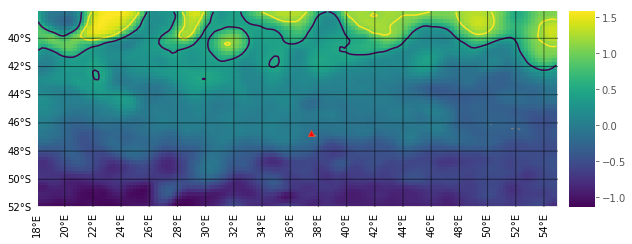

In [12]:
f1 = plt.figure(figsize=(10,12))
m = Basemap(projection='cyl',llcrnrlon=lonmin, urcrnrlon=lonmax, 
            llcrnrlat=latmin, urcrnrlat=latmax, resolution='h',lat_0=0, lon_0=0)
h=m.fillcontinents(color='grey')
h=m.drawmeridians(np.arange(lonmin,lonmax,2),labels=[0, 0, 0, 1],rotation='vertical')
h=m.drawparallels(np.arange(latmin,latmax,2),labels=[1, 0, 0, 0])

#m.pcolormesh(dat.longitude, dat.latitude, np.apply_along_axis(mean,0,u_summer))
#m.pcolormesh(dat.longitude, dat.latitude, np.apply_along_axis(mean,0,v_summer))
levels= [0.49,1.15] #M-APF,N-APF,S_SAF,M-SAF,N-SAF
plt.contour(dat.longitude, dat.latitude, dat.adt[100],levels)#,colors='k')
m.pcolormesh(dat.longitude, dat.latitude, dat.adt[100])
m.plot(37.5,-46.7, marker ='^', markersize=6, markerfacecolor='red', linewidth=0)
m.colorbar()

## Plotting Geostrophic velocities

In [251]:
def plot_geos(component, lonmin,lonmax,latmin,latmax,colourr,cb_title,alpha,space,title,vmin=None,vmax=None,figsize=None):
    """
    Plot var_name variable from netCDF file
    :param path_nc: Name of netCDF file
    :param var_name: Name of variable in netCDF file to plot on map
    :return: Nothing, side-effect: plot an image
    """
    
    component = component.sel(longitude=slice(lonmin, lonmax), latitude=slice(latmin, latmax))
    longs = component.longitude
    lats = component.latitude
    var = np.apply_along_axis(mean,0,component)
    m = Basemap(projection='cyl',llcrnrlon=lonmin, urcrnrlon=lonmax, 
            llcrnrlat=latmin, urcrnrlat=latmax, resolution='h')#,lat_0=0, lon_0=0)
   
    fig = plt.figure(dpi=300)#,figsize=figsize)

    m.drawcoastlines()
    #m.drawcountries() 
    m.fillcontinents(color='grey')
    m.drawmeridians(np.arange(lonmin,lonmax,space),labels=[0, 0, 0, 1],rotation='vertical',alpha=alpha,linewidth=0.5)
    m.drawparallels(np.arange(latmin,latmax,space),labels=[1, 0, 0, 0],alpha=alpha,linewidth=0.5)
    
    x, y = m(*np.meshgrid(longs,lats))
    z = m.pcolormesh(x,y,var,rasterized=True,cmap=colourr,vmin=vmin,vmax=vmax)

    # add colorbar
    cb = m.colorbar(z,"right", pad='2%') #, size="5%"
    cb.set_label(cb_title,fontsize=10, labelpad=-1,weight='bold')
    plt.title(title,fontsize=12)
    plt.xlabel('Longitude',fontsize=12, labelpad=30,weight='bold')
    plt.ylabel('Latitude',fontsize=12, labelpad=30,weight='bold')
    fig.savefig('C:/Users/Sean Evans/Documents/2020/MSc/Computing/MSc/Plots & Dive Tables/All seals/Exploratory analysis/Tile mapping/geo_vel_'+str_component+'_'+which+'.png',dpi=300)
    #plt.show()

C:\Users\Sean Evans\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:3435: MatplotlibDeprecationWarning:

The ishold function was deprecated in version 2.0.

C:\Users\Sean Evans\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:3444: MatplotlibDeprecationWarning:

axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.



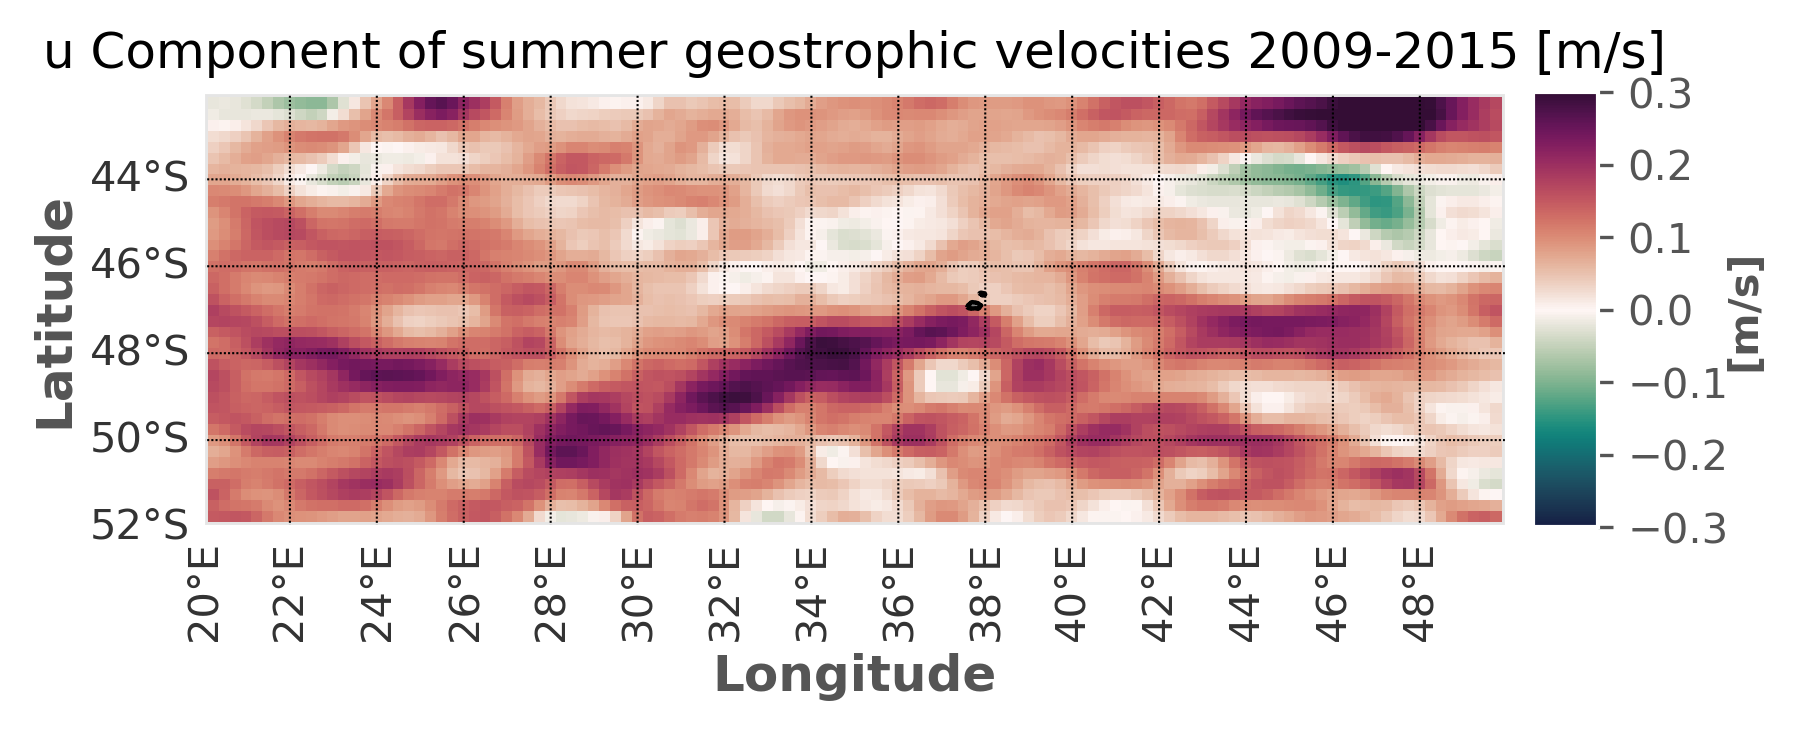

In [253]:
#figsize = (20,20)
space = 2
u = dat.ugos
v = dat.vgos
w = sqrt(square(u)+square(v))
#u_summer = u[0:108]

#choose component to plot:
#component = u #v,w   u:[-0.3,0.3], v:[-0.3,0.3], w:[]
component = summer_mean = u.groupby('time.month').mean(axis=0)[[0,1,2,9,10,11],]
#component = winter_mean = u.groupby('time.month').mean(axis=0)[[3,4,5,6,7,8],]
str_component = 'u'
vmin = -0.3; vmax = 0.3
title = 'u Component of summer geostrophic velocities 2009-2015 [m/s]'
which = 'summer' #all for all data 2009-2015 | summer|winter
cb_title = '[m/s]'
cmap = cmo.curl #or speed,amp,turbid,thermal,haline,curl
plot_geos(component,20,50,-52,-42,colourr=cmap,cb_title=cb_title,alpha=0.8,space=space,title=title,vmin=vmin,vmax=vmax)

## Summer WE

In [239]:
dat = xr.open_mfdataset('C:/Users/Sean Evans/Documents/2020/MSc/Data/Copernicus altimetry/dataset-duacs-rep-global-merged-allsat-phy-l4_1606981195941(all).nc')
lonmin = 32
#lonmin = 18
lonmax = 46
#lonmax = 55
latmin = -50
latmax = -42
dat = dat.sel(longitude=slice(lonmin, lonmax), latitude=slice(latmin, latmax))

u = dat.ugos
v = dat.vgos
w = sqrt(square(u)+square(v))

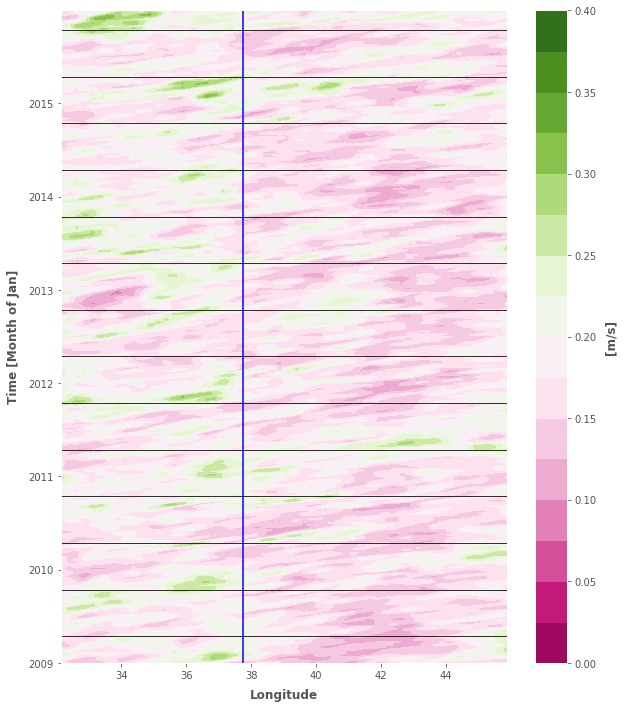

In [240]:
w_lon = np.apply_along_axis(mean,1,w)
w_lon = xr.DataArray(data=w_lon,dims=["days","lon"],
    coords={"days":dat.time.values,
    "lon": dat.longitude.values                                   
    })
marion_lon = 37.73
w_lon_2009_10 = w_lon #[836:1400]
cmap = plt.get_cmap('PiYG')
#cmap = cmo.speed
levels = [0,0.025,0.05,0.075,0.1,0.125,0.15,0.175,0.2,0.225,0.250,0.275,0.3,0.325,0.35,0.375,0.4]#,0.425,0.45,0.475,0.5]#,0.35,0.4,0.45,0.5,0.55,0.6]
fig, ax = plt.subplots(figsize=(10,12))
contourf(w_lon_2009_10.lon.values,w_lon_2009_10.days.values,w_lon_2009_10,cmap=cmap, levels=levels,vmin=0,vmax=0.4)
ax.vlines(x=marion_lon, colors='blue', ymin=w_lon_2009_10[0].days.values, ymax=w_lon_2009_10[2555].days.values)
ax.hlines(y=numpy.datetime64('2009-04-15T00:00:00.000000000'), colors='black', xmin=w_lon_2009_10[0,0].lon.values, xmax=w_lon_2009_10[0,55].lon.values,linewidth=1,alpha=0.8)
ax.hlines(y=numpy.datetime64('2009-10-15T00:00:00.000000000'), colors='black', xmin=w_lon_2009_10[0,0].lon.values, xmax=w_lon_2009_10[0,55].lon.values,linewidth=1,alpha=0.8)
ax.hlines(y=numpy.datetime64('2010-04-15T00:00:00.000000000'), colors='black', xmin=w_lon_2009_10[0,0].lon.values, xmax=w_lon_2009_10[0,55].lon.values,linewidth=1,alpha=0.8)
ax.hlines(y=numpy.datetime64('2010-10-15T00:00:00.000000000'), colors='black', xmin=w_lon_2009_10[0,0].lon.values, xmax=w_lon_2009_10[0,55].lon.values,linewidth=1,alpha=0.8)
ax.hlines(y=numpy.datetime64('2011-04-15T00:00:00.000000000'), colors='black', xmin=w_lon_2009_10[0,0].lon.values, xmax=w_lon_2009_10[0,55].lon.values,linewidth=1,alpha=0.8)
ax.hlines(y=numpy.datetime64('2011-10-15T00:00:00.000000000'), colors='black', xmin=w_lon_2009_10[0,0].lon.values, xmax=w_lon_2009_10[0,55].lon.values,linewidth=1,alpha=0.8)
ax.hlines(y=numpy.datetime64('2012-04-15T00:00:00.000000000'), colors='black', xmin=w_lon_2009_10[0,0].lon.values, xmax=w_lon_2009_10[0,55].lon.values,linewidth=1,alpha=0.8)
ax.hlines(y=numpy.datetime64('2012-10-15T00:00:00.000000000'), colors='black', xmin=w_lon_2009_10[0,0].lon.values, xmax=w_lon_2009_10[0,55].lon.values,linewidth=1,alpha=0.8)
ax.hlines(y=numpy.datetime64('2013-04-15T00:00:00.000000000'), colors='black', xmin=w_lon_2009_10[0,0].lon.values, xmax=w_lon_2009_10[0,55].lon.values,linewidth=1,alpha=0.8)
ax.hlines(y=numpy.datetime64('2013-10-15T00:00:00.000000000'), colors='black', xmin=w_lon_2009_10[0,0].lon.values, xmax=w_lon_2009_10[0,55].lon.values,linewidth=1,alpha=0.8)
ax.hlines(y=numpy.datetime64('2014-04-15T00:00:00.000000000'), colors='black', xmin=w_lon_2009_10[0,0].lon.values, xmax=w_lon_2009_10[0,55].lon.values,linewidth=1,alpha=0.8)
ax.hlines(y=numpy.datetime64('2014-10-15T00:00:00.000000000'), colors='black', xmin=w_lon_2009_10[0,0].lon.values, xmax=w_lon_2009_10[0,55].lon.values,linewidth=1,alpha=0.8)
ax.hlines(y=numpy.datetime64('2015-04-15T00:00:00.000000000'), colors='black', xmin=w_lon_2009_10[0,0].lon.values, xmax=w_lon_2009_10[0,55].lon.values,linewidth=1,alpha=0.8)
ax.hlines(y=numpy.datetime64('2015-10-15T00:00:00.000000000'), colors='black', xmin=w_lon_2009_10[0,0].lon.values, xmax=w_lon_2009_10[0,55].lon.values,linewidth=1,alpha=0.8)
cb = plt.colorbar()
cb.set_label('[m/s]',fontsize=12, labelpad=8,weight='bold')
plt.xlabel('Longitude',fontsize=12, labelpad=8,weight='bold')
plt.ylabel('Time [Month of Jan]',fontsize=12, labelpad=8,weight='bold')
# Stop matplotlib providing clever axes range padding
#plt.axis('tight')
fig.savefig('C:/Users/Sean Evans/Documents/2020/MSc/Computing/MSc/Plots & Dive Tables/All seals/Exploratory analysis/Tile mapping/EKE_hofmoller_zoomed_in.png',dpi=300)


## Looking at winter WE extended

In [241]:
dat = xr.open_mfdataset('C:/Users/Sean Evans/Documents/2020/MSc/Data/Copernicus altimetry/dataset-duacs-rep-global-merged-allsat-phy-l4_1606981195941(all).nc')
#lonmin = 32
lonmin = 18
#lonmax = 46
lonmax = 55
latmin = -50
latmax = -42
dat = dat.sel(longitude=slice(lonmin, lonmax), latitude=slice(latmin, latmax))

u = dat.ugos
v = dat.vgos
w = sqrt(square(u)+square(v))

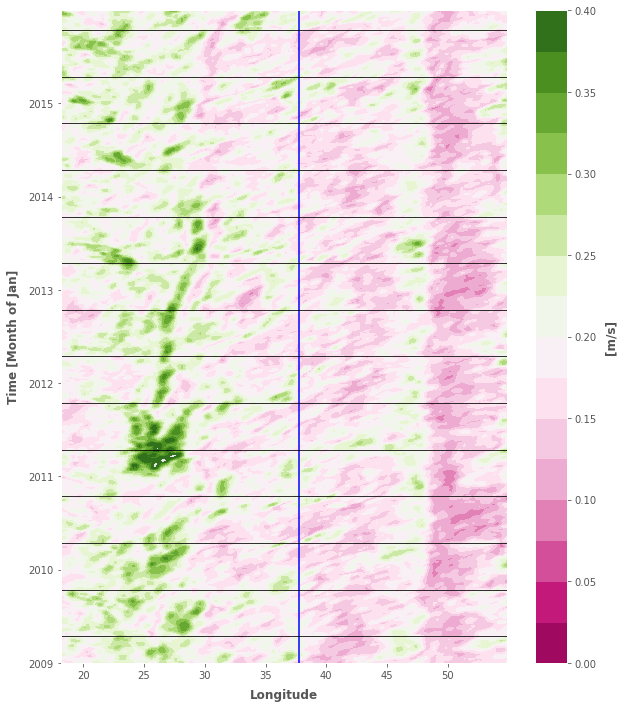

In [242]:
w_lon = np.apply_along_axis(mean,1,w)
w_lon = xr.DataArray(data=w_lon,dims=["days","lon"],
    coords={"days":dat.time.values,
    "lon": dat.longitude.values                                   
    })
marion_lon = 37.73
w_lon_2009_10 = w_lon #[836:1400]
cmap = plt.get_cmap('PiYG')
#cmap = cmo.speed
levels = [0,0.025,0.05,0.075,0.1,0.125,0.15,0.175,0.2,0.225,0.250,0.275,0.3,0.325,0.35,0.375,0.4]#,0.425,0.45,0.475,0.5]#,0.35,0.4,0.45,0.5,0.55,0.6]
fig, ax = plt.subplots(figsize=(10,12))
contourf(w_lon_2009_10.lon.values,w_lon_2009_10.days.values,w_lon_2009_10,cmap=cmap,levels=levels,vmin=0,vmax=0.4)
ax.vlines(x=marion_lon, colors='blue', ymin=w_lon_2009_10[0].days.values, ymax=w_lon_2009_10[2555].days.values)
ax.hlines(y=numpy.datetime64('2009-04-15T00:00:00.000000000'), colors='black', xmin=w_lon_2009_10[0,0].lon.values, xmax=w_lon_2009_10[0,147].lon.values,linewidth=1,alpha=0.8)
ax.hlines(y=numpy.datetime64('2009-10-15T00:00:00.000000000'), colors='black', xmin=w_lon_2009_10[0,0].lon.values, xmax=w_lon_2009_10[0,147].lon.values,linewidth=1,alpha=0.8)
ax.hlines(y=numpy.datetime64('2010-04-15T00:00:00.000000000'), colors='black', xmin=w_lon_2009_10[0,0].lon.values, xmax=w_lon_2009_10[0,147].lon.values,linewidth=1,alpha=0.8)
ax.hlines(y=numpy.datetime64('2010-10-15T00:00:00.000000000'), colors='black', xmin=w_lon_2009_10[0,0].lon.values, xmax=w_lon_2009_10[0,147].lon.values,linewidth=1,alpha=0.8)
ax.hlines(y=numpy.datetime64('2011-04-15T00:00:00.000000000'), colors='black', xmin=w_lon_2009_10[0,0].lon.values, xmax=w_lon_2009_10[0,147].lon.values,linewidth=1,alpha=0.8)
ax.hlines(y=numpy.datetime64('2011-10-15T00:00:00.000000000'), colors='black', xmin=w_lon_2009_10[0,0].lon.values, xmax=w_lon_2009_10[0,147].lon.values,linewidth=1,alpha=0.8)
ax.hlines(y=numpy.datetime64('2012-04-15T00:00:00.000000000'), colors='black', xmin=w_lon_2009_10[0,0].lon.values, xmax=w_lon_2009_10[0,147].lon.values,linewidth=1,alpha=0.8)
ax.hlines(y=numpy.datetime64('2012-10-15T00:00:00.000000000'), colors='black', xmin=w_lon_2009_10[0,0].lon.values, xmax=w_lon_2009_10[0,147].lon.values,linewidth=1,alpha=0.8)
ax.hlines(y=numpy.datetime64('2013-04-15T00:00:00.000000000'), colors='black', xmin=w_lon_2009_10[0,0].lon.values, xmax=w_lon_2009_10[0,147].lon.values,linewidth=1,alpha=0.8)
ax.hlines(y=numpy.datetime64('2013-10-15T00:00:00.000000000'), colors='black', xmin=w_lon_2009_10[0,0].lon.values, xmax=w_lon_2009_10[0,147].lon.values,linewidth=1,alpha=0.8)
ax.hlines(y=numpy.datetime64('2014-04-15T00:00:00.000000000'), colors='black', xmin=w_lon_2009_10[0,0].lon.values, xmax=w_lon_2009_10[0,147].lon.values,linewidth=1,alpha=0.8)
ax.hlines(y=numpy.datetime64('2014-10-15T00:00:00.000000000'), colors='black', xmin=w_lon_2009_10[0,0].lon.values, xmax=w_lon_2009_10[0,147].lon.values,linewidth=1,alpha=0.8)
ax.hlines(y=numpy.datetime64('2015-04-15T00:00:00.000000000'), colors='black', xmin=w_lon_2009_10[0,0].lon.values, xmax=w_lon_2009_10[0,147].lon.values,linewidth=1,alpha=0.8)
ax.hlines(y=numpy.datetime64('2015-10-15T00:00:00.000000000'), colors='black', xmin=w_lon_2009_10[0,0].lon.values, xmax=w_lon_2009_10[0,147].lon.values,linewidth=1,alpha=0.8)
cb = plt.colorbar()
cb.set_label('[m/s]',fontsize=12, labelpad=8,weight='bold')
plt.xlabel('Longitude',fontsize=12, labelpad=8,weight='bold')
plt.ylabel('Time [Month of Jan]',fontsize=12, labelpad=8,weight='bold')
# Stop matplotlib providing clever axes range padding
#plt.axis('tight')
fig.savefig('C:/Users/Sean Evans/Documents/2020/MSc/Computing/MSc/Plots & Dive Tables/All seals/Exploratory analysis/Tile mapping/EKE_hofmoller_zoomed_out.png',dpi=300)


# Loading in seal temperature data and visualizing distributions

In [2]:
dives_pdsi=readRDS('C:/Users/Sean Evans/Documents/2020/MSc/Computing/MSc/Plots & Dive Tables/dives_pdsi.rds')
dives_pdsi = pandas2ri.ri2py(dives_pdsi)

C:\Users\Sean Evans\Anaconda3\lib\site-packages\rpy2-2.9.4-py3.6-win-amd64.egg\rpy2\robjects\pandas2ri.py:191: FutureWarning:

from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.



In [206]:
def plot_map(var, lonmin,lonmax,latmin,latmax,colourr,cb_title):
    """
    Plot var_name variable from netCDF file
    :param path_nc: Name of netCDF file
    :param var_name: Name of variable in netCDF file to plot on map
    :return: Nothing, side-effect: plot an image
    """

    var = var.sel(longitude=slice(lonmin, lonmax), latitude=slice(latmin, latmax))
    longs = var.longitude
    lats = var.latitude
    m = Basemap(projection='cyl',llcrnrlon=lonmin, urcrnrlon=lonmax, 
            llcrnrlat=latmin, urcrnrlat=latmax, resolution='h')#,lat_0=0, lon_0=0)
   
    f1 = plt.figure(figsize=(10,12))

    m.drawcoastlines()
    #m.drawcountries() 
    m.fillcontinents(color='grey')
    m.drawmeridians(np.arange(lonmin,lonmax,5),labels=[0, 0, 0, 1],rotation='vertical')
    m.drawparallels(np.arange(latmin,latmax,5),labels=[1, 0, 0, 0])
    x, y = m(*np.meshgrid(longs,lats))
    z = m.pcolormesh(x,y,var,rasterized=True,cmap=colourr)
    #z = m.imshow(x,y,var,colourr)

    # add colorbar
    cb = m.colorbar(z,"right", pad='2%') #, size="5%"
    #cb.set_label('Land cover percentage '+var_name+' in '+os.path.basename(path_nc))
    cb.set_label(cb_title)


    #plt.show()

In [106]:
therm_depth = dives_pdsi[dives_pdsi.season=='summer'].groupby(['lat','lon']).mean()
therm_depth = therm_depth.therm_depth.unstack(level=-1)
longs = therm_depth.columns.values
lats = therm_depth.index.values
therm_depth = xr.DataArray(data=therm_depth,dims=["lon","lat"],
    coords={"lon":longs,
    "lat": lats
})
therm_depth

<xarray.DataArray (lon: 3183, lat: 3183)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lon      (lon) float64 31.41 31.42 31.45 31.46 31.47 31.47 31.47 31.47 ...
  * lat      (lat) float64 -50.42 -50.41 -50.39 -50.37 -50.34 -50.29 -50.29 ...

C:\Users\Sean Evans\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:3435: MatplotlibDeprecationWarning:

The ishold function was deprecated in version 2.0.

C:\Users\Sean Evans\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:3444: MatplotlibDeprecationWarning:

axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.

C:\Users\Sean Evans\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:3310: MatplotlibDeprecationWarning:

The ishold function was deprecated in version 2.0.

C:\Users\Sean Evans\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:3317: MatplotlibDeprecationWarning:

axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.



ValueError: 'norm' must be an instance of 'mcolors.Normalize'

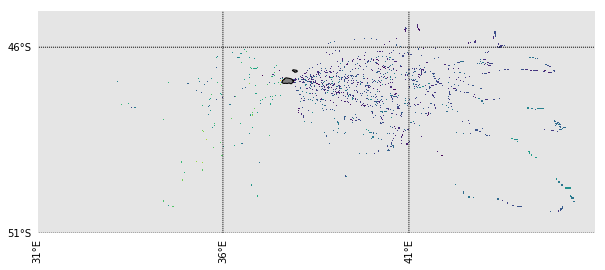

In [107]:
lonmin = 31
#lonmin = 18
lonmax = 46
#lonmax = 55
latmax = -45
#latmax = -38
latmin = -51
#latmin = -52
plot_map(therm_depth,lonmin,lonmax,latmin,latmax)

In [55]:
htime = dives_pdsi[dives_pdsi.season=='summer'].groupby(['lat','lon']).mean()
htime = htime.hunting_time.unstack(level=-1)
longs = htime.columns.values
lats = htime.index.values
htime = xr.DataArray(data=htime,dims=["lon","lat"],
    coords={"lon":longs,
    "lat": lats
})
htime

<xarray.DataArray (lon: 3183, lat: 3183)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lon      (lon) float64 31.41 31.42 31.45 31.46 31.47 31.47 31.47 31.47 ...
  * lat      (lat) float64 -50.42 -50.41 -50.39 -50.37 -50.34 -50.29 -50.29 ...

C:\Users\Sean Evans\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:3435: MatplotlibDeprecationWarning:

The ishold function was deprecated in version 2.0.

C:\Users\Sean Evans\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:3444: MatplotlibDeprecationWarning:

axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.



ImportError: warpimage method requires PIL (http://www.pythonware.com/products/pil)

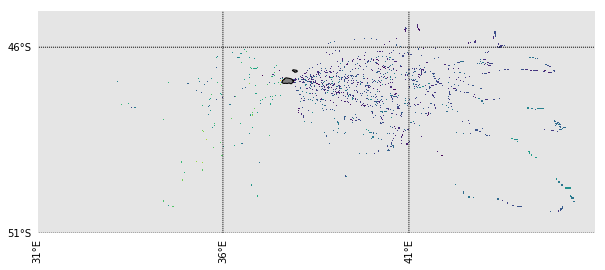

In [94]:
lonmin = 31
#lonmin = 18
lonmax = 46
#lonmax = 55
latmax = -45
#latmax = -38
latmin = -51
#latmin = -52

f1 = plt.figure(figsize=(10,12))
m = Basemap(projection='cyl',llcrnrlon=lonmin, urcrnrlon=lonmax, 
            llcrnrlat=latmin, urcrnrlat=latmax, resolution='h',lat_0=0, lon_0=0)



m.drawcoastlines()
h=m.fillcontinents(color='grey')
h=m.drawmeridians(np.arange(lonmin,lonmax,5),labels=[0, 0, 0, 1],rotation='vertical')
h=m.drawparallels(np.arange(latmin,latmax,5),labels=[1, 0, 0, 0])
m.pcolormesh(therm_depth.lon,therm_depth.lat,therm_depth,rasterized=True)
m.etopo()
#m.bluemarble()
#m.shadedrelief()
m.colorbar()

## Plotting bathymetry

In [2]:
#Fabien bathy
#namefile = 'C:/Users/Sean Evans/Documents/2020/MSc/Data/Fabien data and scripts (Animating geophysical data)/GLO-MFC_001_030_mask_bathy.nc'
#Gebco
#namefile = 'C:/Users/Sean Evans/Documents/2020/MSc/Data/GRIDONE_2D.nc'
namefile = 'C:/Users/Sean Evans/Documents/2020/MSc/Data/gebco_2020_n-20.478515625_s-65.33789277076721_w6.372072458267214_e72.9580078125.nc'
dat = xr.open_mfdataset(namefile)

In [3]:
def plot_map(var, lonmin,lonmax,latmin,latmax,colourr,cb_title,alpha,space,title):
    """
    Plot var_name variable from netCDF file
    :param path_nc: Name of netCDF file
    :param var_name: Name of variable in netCDF file to plot on map
    :return: Nothing, side-effect: plot an image
    """
    #Fabien bathy
    #var = var.sel(longitude=slice(lonmin, lonmax), latitude=slice(latmin, latmax))
    #longs = var.longitude
    #lats = var.latitude
    
    ##Gebco
    var = var.sel(lon=slice(lonmin, lonmax), lat=slice(latmin, latmax))
    longs = var.lon
    lats = var.lat

    m = Basemap(projection='cyl',llcrnrlon=lonmin, urcrnrlon=lonmax, 
            llcrnrlat=latmin, urcrnrlat=latmax, resolution='h')#,lat_0=0, lon_0=0)
   
    f1 = plt.figure(figsize=(10,12))

    m.drawcoastlines()
    #m.drawcountries() 
    m.fillcontinents(color='grey')
    #zoomed out
    #m.drawmeridians(np.arange(lonmin,lonmax,5),labels=[0, 0, 0, 1],rotation='vertical')
    #m.drawparallels(np.arange(latmin,latmax,5),labels=[1, 0, 0, 0])
    #zoomed in
    m.drawmeridians(np.arange(lonmin,lonmax,space),labels=[0, 0, 0, 1],rotation='vertical',alpha=alpha,linewidth=0.5)
    m.drawparallels(np.arange(latmin,latmax,space),labels=[1, 0, 0, 0],alpha=alpha,linewidth=0.5)
    
    x, y = m(*np.meshgrid(longs,lats))
    z = m.pcolormesh(x,y,var,rasterized=True,cmap=colourr,vmin=0,vmax=6000)
    #z = m.imshow(x,y,var,colourr)

    # add colorbar
    cb = m.colorbar(z,"right", pad='2%') #, size="5%"
    #cb.set_label('Land cover percentage '+var_name+' in '+os.path.basename(path_nc))
    cb.set_label(cb_title)
    plt.title(title)

    #plt.show()

C:\Users\Sean Evans\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:3435: MatplotlibDeprecationWarning:

The ishold function was deprecated in version 2.0.

C:\Users\Sean Evans\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:3444: MatplotlibDeprecationWarning:

axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.



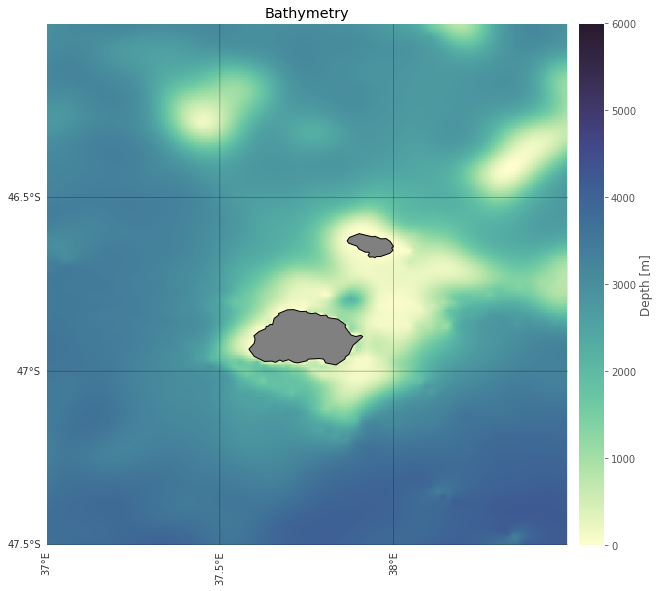

In [5]:
#zoom = 'in_f'; space = 1
zoom = 'in_h_updated'; space = 0.5

cb_title = 'Depth [m]'
title = 'Bathymetry'
#Fabien bathy
#bathy = dat.deptho
#Gebco
bathy = abs(dat.elevation)
plot_map(bathy,37,38.5,-47.5,-46,cmo.deep,cb_title=cb_title,alpha=0.8,space=space,title=title)
savefig('C:/Users/Sean Evans/Documents/2020/MSc/Computing/MSc/Plots & Dive Tables/All seals/Exploratory analysis/Tile mapping/bathy_zoomed_'+zoom+'.png')